In [1]:
# import os
# os.chdir("./unet")
import config
import os
import glob
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from imgaug import augmenters as iaa
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 100

#### Get image tiles as a generator

In [3]:
def get_image_data(num_images_to_get=32, normalise=True, image_folder = config.TEST_IMAGE_FOLDER, augment=False):
    # Get list of files
    satellite_images = glob.glob(image_folder + config.SAT_IMAGE_FOLDER + "/0/*.png")
    if len(satellite_images) == 0:
        raise FileNotFoundError(image_folder + config.SAT_IMAGE_FOLDER + " doesn't contain any images!")
    if normalise:
        # first provide a sample of images for featurewise normalisation
        X_sample, y_sample = next(get_image_data(num_images_to_get=1000, normalise=False))

        mean_sat_color = np.mean(X_sample.reshape(X_sample.shape[0]*X_sample.shape[1]*X_sample.shape[2], 3), axis=0)
        variance_sat_color = np.var(X_sample.reshape(X_sample.shape[0]*X_sample.shape[1]*X_sample.shape[2], 3), axis=0)

        #mean_mask_color = np.mean(y_sample.reshape(y_sample.shape[0]*y_sample.shape[1]*y_sample.shape[2], 1), axis=0)
        #variance_mask_color = np.var(y_sample.reshape(y_sample.shape[0]*y_sample.shape[1]*y_sample.shape[2], 1), axis=0)
        
        del X_sample
        del y_sample

    while True:
        np.random.shuffle(satellite_images)

        # Preallocate array of image stacks
        satellite_stacked = np.zeros((num_images_to_get, 224, 224, 3), dtype=np.float32)
        mask_stacked = np.zeros((num_images_to_get, 224, 224, 1), dtype=np.float32)

        for i, image in enumerate(satellite_images[:num_images_to_get]):
            image = image.split("/")[-1]
            satellite_stacked[i] = np.array(Image.open(image_folder + config.SAT_IMAGE_FOLDER + "/0/" + image))
            mask_stacked[i] = np.array(Image.open(image_folder + config.MASK_IMAGE_FOLDER + "/0/" + image)).reshape(224,224, 1)/255.0

        if augment:
            augmenters = iaa.Sequential([
                iaa.Add((-2, 2), per_channel=0.5),
                iaa.Sharpen(alpha=0.05),
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.AdditiveGaussianNoise(scale=(0,0.01*255)),
            ])
            satellite_stacked = augmenters.augment_images(satellite_stacked)
        if normalise:
            satellite_stacked = (satellite_stacked - mean_sat_color)/np.sqrt(variance_sat_color)
            #mask_stacked = (mask_stacked - mean_mask_color)/np.sqrt(variance_mask_color)
        yield satellite_stacked, mask_stacked

In [4]:
X_sample, y_sample = next(get_image_data(num_images_to_get=1000, normalise=False, image_folder=config.DATA_FOLDER + "/tiles/train/"))

mean_sat_color = np.mean(X_sample.reshape(X_sample.shape[0]*X_sample.shape[1]*X_sample.shape[2], 3), axis=0)
variance_sat_color = np.var(X_sample.reshape(X_sample.shape[0]*X_sample.shape[1]*X_sample.shape[2], 3), axis=0)

del X_sample
del y_sample

In [5]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1.0)

In [6]:
import sys
sys.path.append("./unet/")
from unet.model import get_vgg_7conv
import unet.metrics

model = get_vgg_7conv(config.ISZ, config.N_CHANNELS, config.NUM_CLASSES)

model.load_weights(config.WEIGHTS_FOLDER + "model_with_aug.h5")

Using TensorFlow backend.


#### How many test images do we have?

In [8]:
!ls -l Data/tiles/PV/test/masks/0/ | wc -l

2347


#### Run test images through the model to predict masks and compare with the ground truth masks

In [9]:
N_TILES = 1000

test_data = get_image_data(N_TILES, True, image_folder=config.TEST_IMAGE_FOLDER)

In [10]:
import pickle
try:
    validation_df = pd.read_pickle(config.DATA_FOLDER + "/validation.p")
    raise FileNotFoundError
except FileNotFoundError:
    sats, masks = next(test_data)
    model_predictions = model.predict(sats).reshape(N_TILES, 224, 224)
    
    validation_df = pd.DataFrame({"ground_truth": list(masks),
              "satellite_image": list(sats),
              "model_prediction": list(model_predictions),
              "dice_coeff": list(map(lambda i: dice_coef(masks[i], model_predictions[i]), range(model_predictions.shape[0])))})
    validation_df.to_pickle(config.DATA_FOLDER + "/validation.p")

sorted_df = validation_df.sort_values("dice_coeff")

#### Here's a histogram showing the quality of prediction

In [ ]:
#!pip install altair

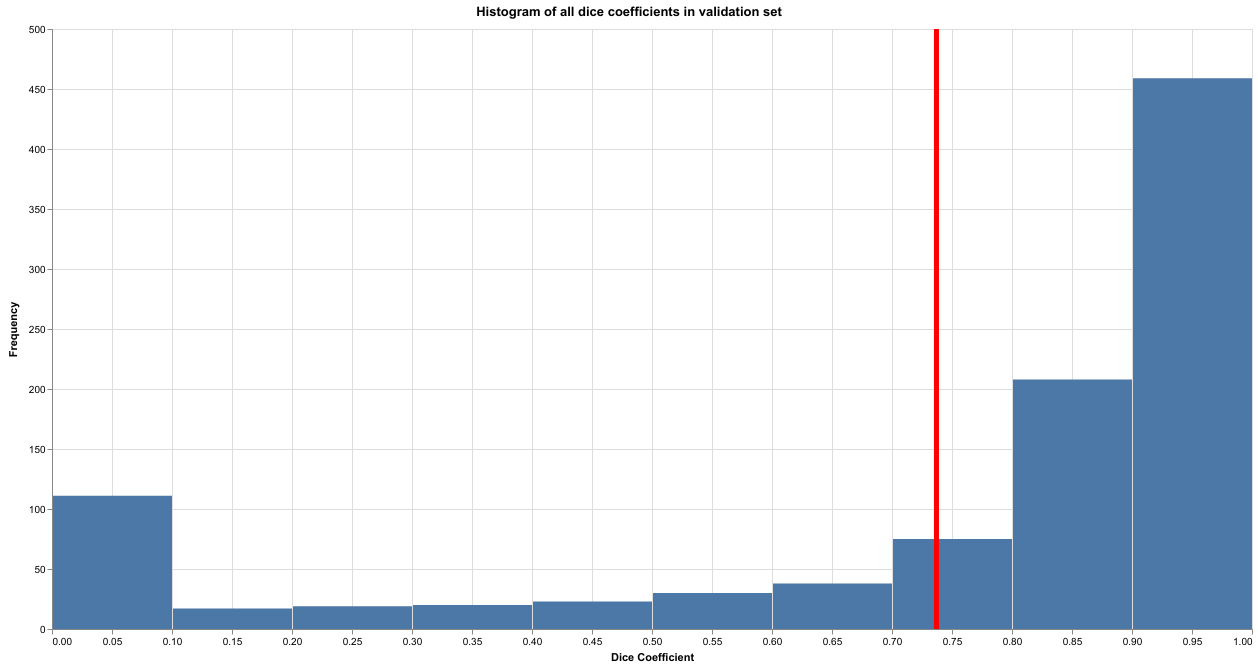

In [11]:
import altair as alt
#alt.renderers.enable('notebook')
alt.themes.enable("opaque")

bar = alt.Chart(validation_df[["dice_coeff"]], width=1200, height=600).mark_bar().encode(
    alt.X('dice_coeff', bin=True, axis=None),
    alt.Y('count()', title = "Frequency")
).properties(title="Histogram of all dice coefficients in validation set")

rule = alt.Chart(validation_df[["dice_coeff"]]).mark_rule(color='red').encode(
    alt.X('mean(dice_coeff):Q', title="Dice Coefficient"),
    size=alt.value(5)
)

bar + rule

#### Let's look through all the test predictions, sorted by increasing accuracy
You can press the Run Interact button to load another one

In [ ]:
%matplotlib inline
from ipywidgets import interact_manual, widgets

def g(i):
    sat, mask, model_prediction = sorted_df.iloc[i][["satellite_image", "ground_truth", "model_prediction"]]#next(test_data)
    #model_prediction = model_predictions[0]#model.predict(sat).reshape(224,224)
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12,12), dpi=100)
    f.patch.set_facecolor("white")
    f.tight_layout()
    f.subplots_adjust(top=0.95)
    ax1.set_title("Ground truth")
    ax2.set_title("Prediction")
    ax3.set_title("Satellite image")
    ax4.set_title("Normalised image")

    f.suptitle('Dice coefficient: {0:0.2f}'.format(dice_coef(mask.reshape((224,224)), model_prediction)))
    ax3.imshow((sat*np.sqrt(variance_sat_color) + mean_sat_color).astype(int))
    ax4.imshow(sat)
    ax1.imshow(mask.reshape(224,224))
    ax2.imshow(model_prediction)
    #f.show()
    #return f

interact_manual.options(manual_name="Get image predictions")(g, i=widgets.IntSlider(value=0, max=N_TILES-1))

### Test it with a screenshot from Google Maps
The model seems to work well with Google Maps satellite images but only if it has the same scale as our training data. There may be ways to improve this using image augmentation with scaling.

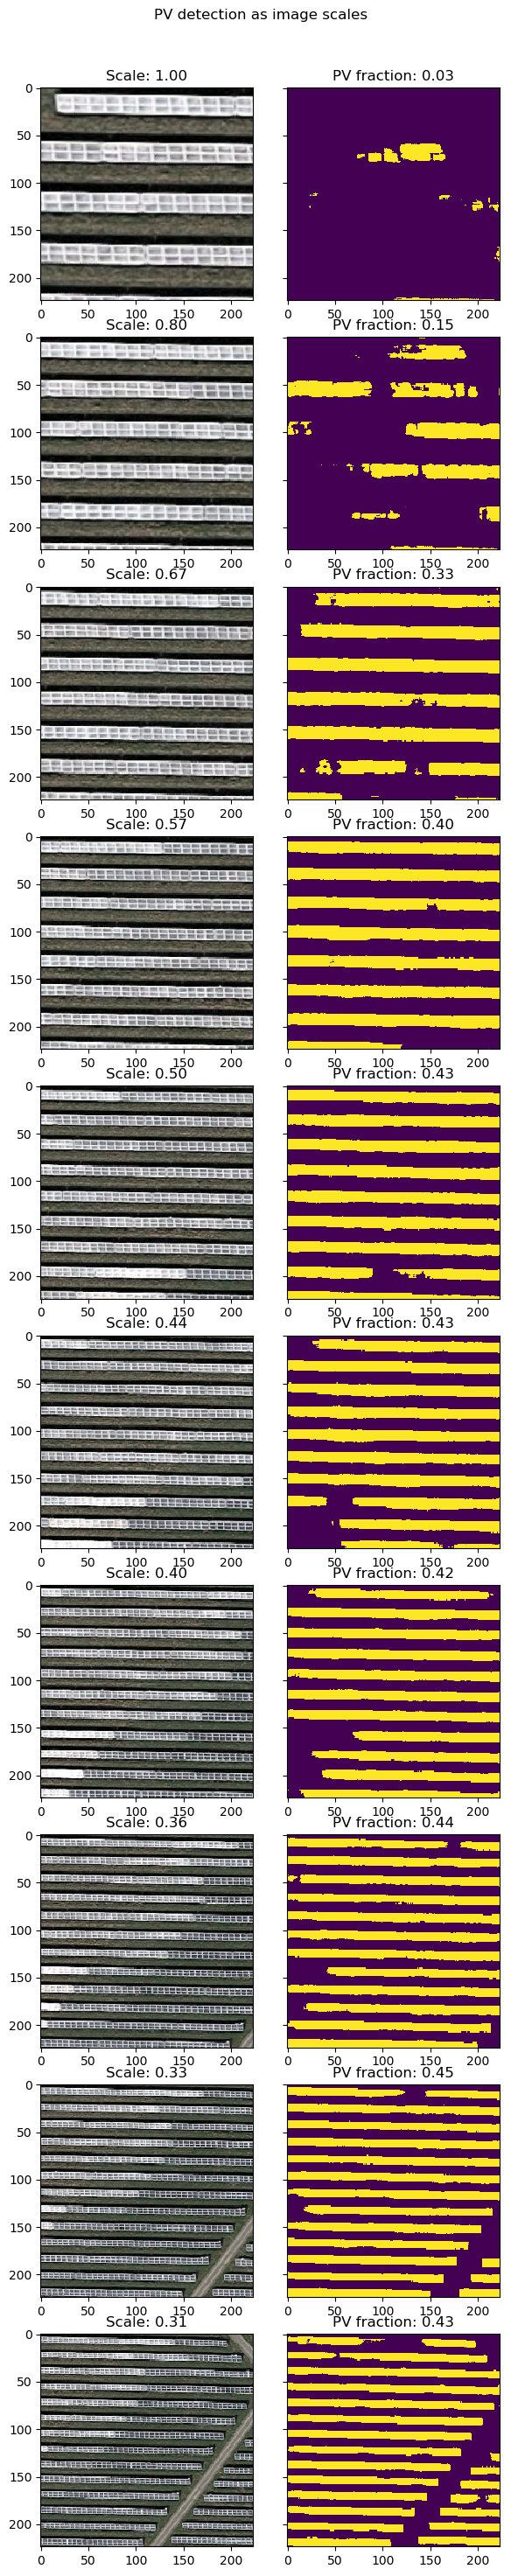

In [133]:
range_to_measure = np.arange(1.,3.5, 0.25)
mean_pv_pixels = []

fig, axes = plt.subplots(len(range_to_measure), 2, sharey='row', figsize=(6,6*len(range_to_measure)/2), dpi=100)
fig.tight_layout()
fig.suptitle("PV detection as image scales")
fig.subplots_adjust(top=0.95)
for i, scale in enumerate(range_to_measure):
    sat = np.asarray(Image.open(config.DATA_FOLDER + "/google_screenshot.png").resize((int(1705/scale), int(1270/scale))))[0*224:1*224, 1*224:2*224]
    axes[i][0].imshow(sat)
    sat = (sat - mean_sat_color)/np.sqrt(variance_sat_color)
    prediction = model.predict(sat.reshape((1, *sat.shape)))[0]
    mean_pv_pixels.append(np.mean(prediction))
    axes[i][1].imshow(prediction.reshape(224,224))
    axes[i][0].set_title("Scale: {0:.2f}".format(1/scale))
    axes[i][1].set_title("PV fraction: {0:.2f}".format(mean_pv_pixels[i]))

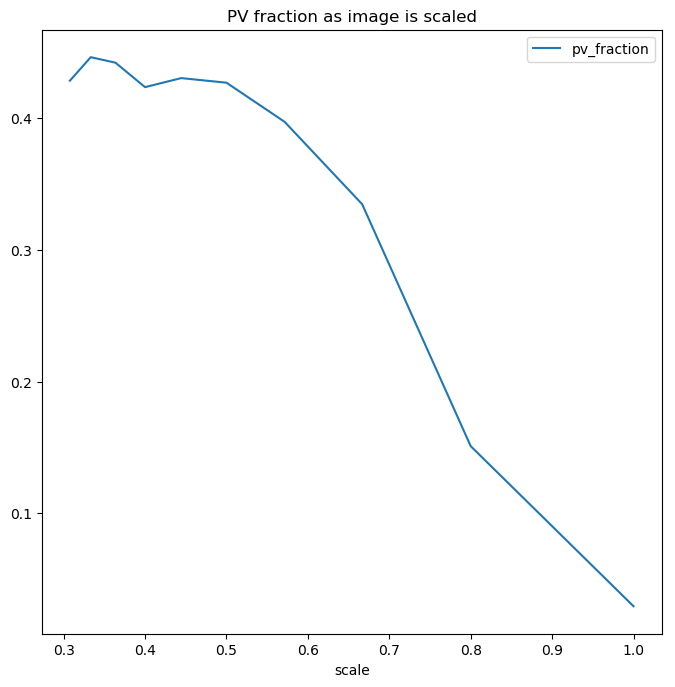

In [134]:
pd.DataFrame(dict(scale=1/range_to_measure, pv_fraction=mean_pv_pixels))\
    .set_index("scale")\
    .plot(title="PV fraction as image is scaled")